In [1]:
import osmnx as ox
import pandas as pd
import geopandas as gpd
import folium

# ------ PARAMETERS ------
target_places = [
    "Sydney, Australia",
    "Melbourne, Australia",
    "Brisbane, Australia",
    "Perth, Australia",
    "Gold Coast, Australia"
]

# Fetch all amenities of type 'fuel'
tags = {"amenity": "fuel"}

# ------ DOWNLOAD AND COMBINE DATA ------
all_cities = []

for place in target_places:
    print(f"Downloading data for {place} ...")
    gdf = ox.features_from_place(place, tags=tags)
    
    city_name = place.split(",")[0]
    gdf['city'] = city_name
    
    # Ensure columns exist
    # OSM often has 'brand', 'name', sometimes 'operator', etc.
    for col in ['name', 'brand', 'operator', 'addr:street', 'start_date', 'opening_hours']:
        if col not in gdf.columns:
            gdf[col] = None

    subset = gdf[['name', 'geometry', 'brand', 'operator', 'addr:street', 'start_date', 'opening_hours', 'city']].copy()
    all_cities.append(subset)

all_fuel = pd.concat(all_cities).reset_index(drop=True)
print(f"Total fuel station records fetched: {len(all_fuel)}")

# ------ PREPARE DATA FOR EXPORT / TABLEAU ------
all_fuel = all_fuel[all_fuel['geometry'].notnull()].copy()
all_fuel['point_geom'] = all_fuel['geometry'].apply(lambda geom: geom.representative_point())
all_fuel['lon'] = all_fuel['point_geom'].x
all_fuel['lat'] = all_fuel['point_geom'].y

export_cols = ['name', 'brand', 'operator', 'addr:street', 'start_date', 'opening_hours', 'city', 'lon', 'lat']
all_fuel_export = all_fuel[export_cols].copy()

all_fuel_export.to_csv("australian_majorcity_fuel_for_tableau.csv", index=False)
print("Exported data for Tableau to 'australian_majorcity_fuel_for_tableau.csv'")

# ------ CREATE INTERACTIVE FOLIUM MAPS ------
for city in target_places:
    city_name = city.split(",")[0]
    city_ff = all_fuel[all_fuel['city'] == city_name]
    if city_ff.empty:
        print(f"No data for {city_name}, skipping map.")
        continue

    meanlat = city_ff['lat'].mean()
    meanlon = city_ff['lon'].mean()
    m = folium.Map(location=[meanlat, meanlon], zoom_start=11, tiles="CartoDB Positron")

    for idx, row in city_ff.iterrows():
        popup_txt = (
            f"<b>{row['name'] or ''}</b><br>"
            f"Brand: {row['brand'] or 'N/A'}<br>"
            f"Operator: {row['operator'] or 'N/A'}<br>"
            f"Street: {row['addr:street'] or 'N/A'}<br>"
            f"Start Date: {row['start_date'] or 'N/A'}<br>"
            f"Opening Hours: {row['opening_hours'] or 'N/A'}"
        )
        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            radius=5,
            color='red',
            fill=True,
            fill_opacity=0.6,
            popup=folium.Popup(popup_txt, max_width=300)
        ).add_to(m)

    out_name = f"{city_name}_fuelstation_map.html".replace(" ", "_")
    m.save(out_name)
    print(f"Saved interactive map for {city_name}: {out_name}")


Total fuel station records fetched: 2131
Exported data for Tableau to 'australian_majorcity_fuel_for_tableau.csv'
Saved interactive map for Sydney: Sydney_fuelstation_map.html
Saved interactive map for Melbourne: Melbourne_fuelstation_map.html
Saved interactive map for Brisbane: Brisbane_fuelstation_map.html
Saved interactive map for Perth: Perth_fuelstation_map.html
Saved interactive map for Gold Coast: Gold_Coast_fuelstation_map.html


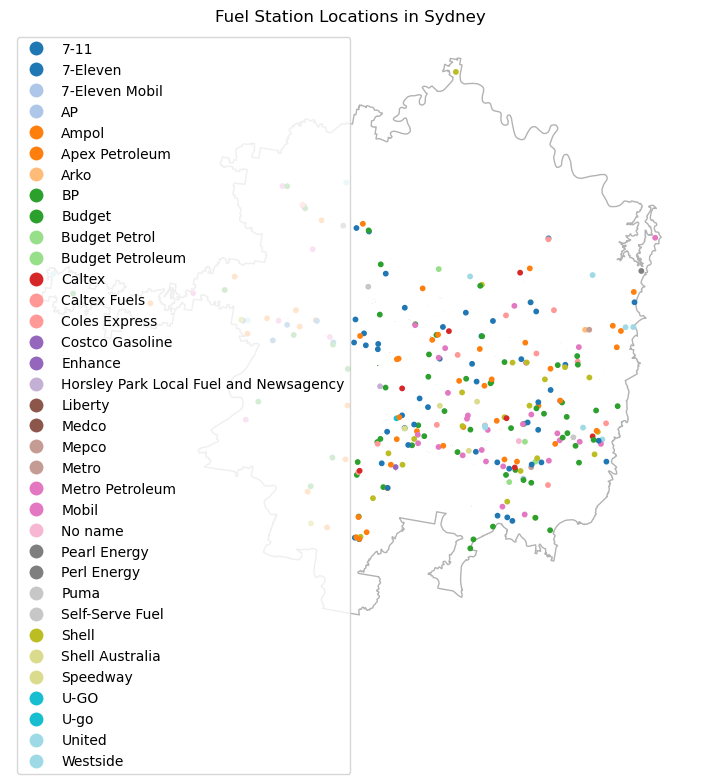

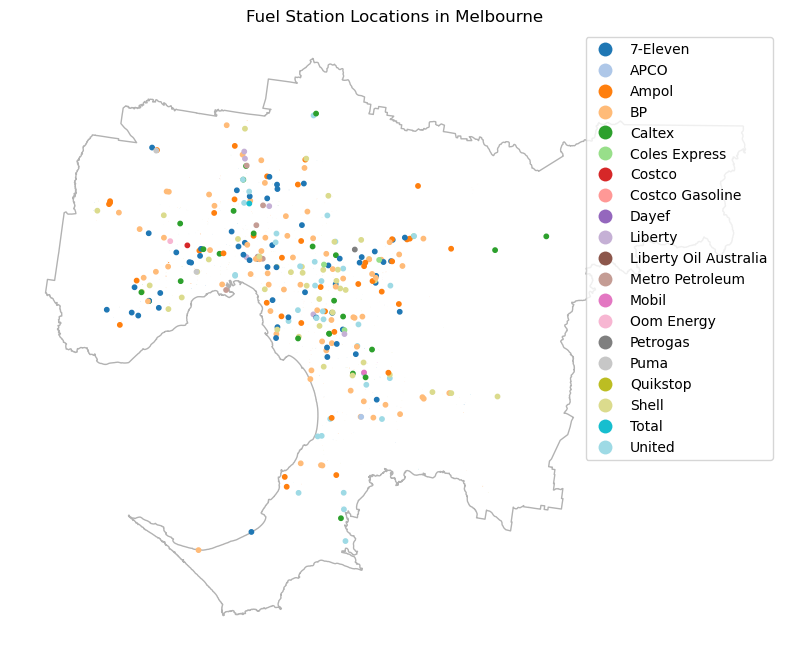

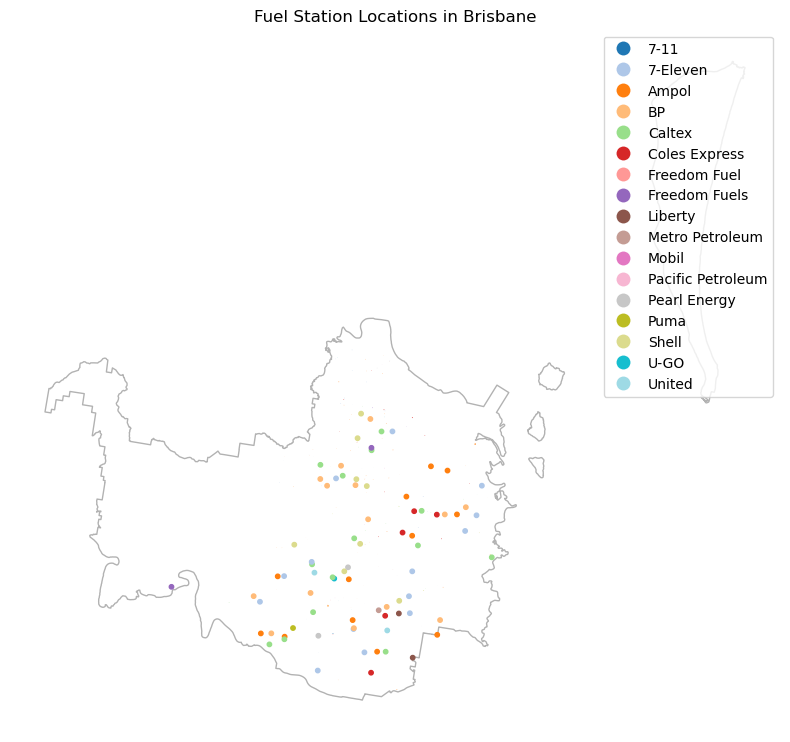

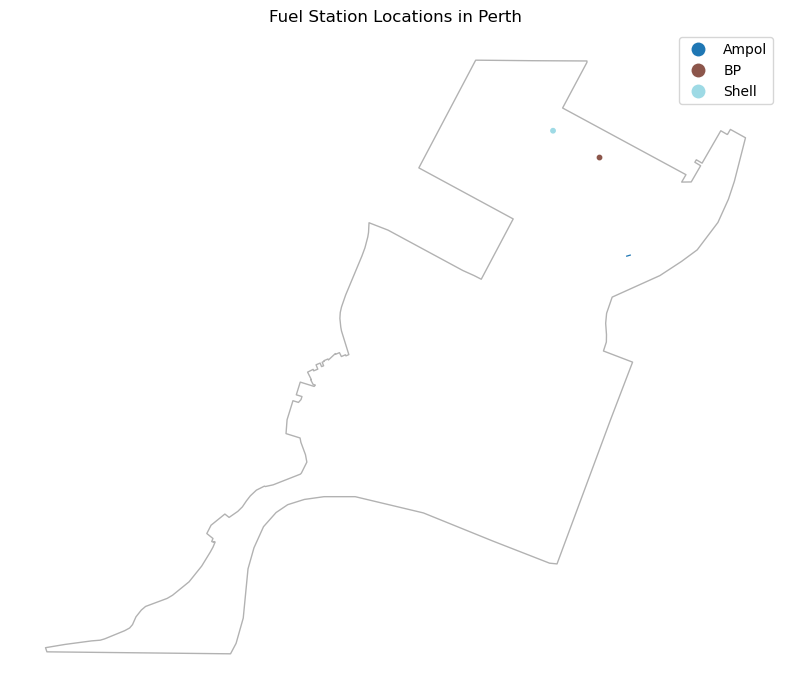

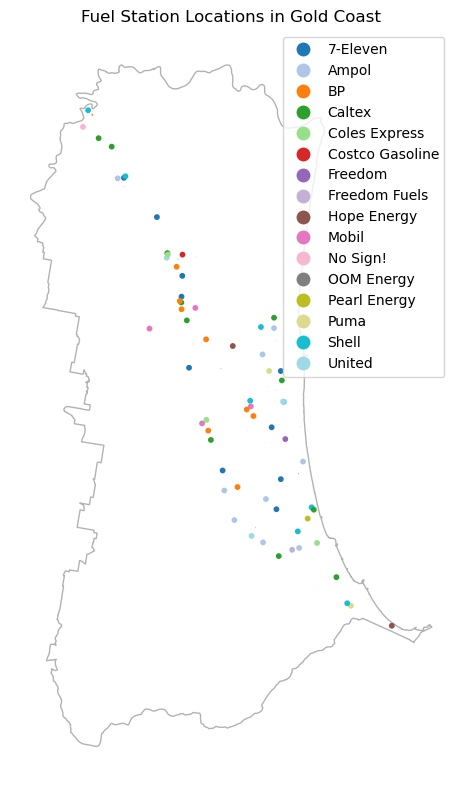

In [3]:
import matplotlib.pyplot as plt

# Plot each city's fuel station locations with city boundary as base map
for city in target_places:
    city_name = city.split(",")[0]
    city_fuel = all_fuel[all_fuel['city'] == city_name]
    city_fuel = city_fuel[city_fuel['geometry'].notnull()]
    
    # Get city boundary polygon from OSMnx
    city_boundary = ox.geocode_to_gdf(city)
    
    ax = city_boundary.plot(facecolor='white', edgecolor='black', figsize=(8, 8), alpha=0.3)
    # Scatter plot of fuel stations colored by brand (if available)
    city_fuel.plot(ax=ax, marker='o', column='brand', cmap='tab20', markersize=10, legend=True)
    
    plt.title(f"Fuel Station Locations in {city_name}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
